In [106]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

#### Sample 데이터셋 생성 

In [111]:
x,y = make_moons(noise=0.2, n_samples = 3000, random_state = 50120057)
x = scale(x)
x = x.astype(floatX)
y = y.astype(floatX)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size =0.3)

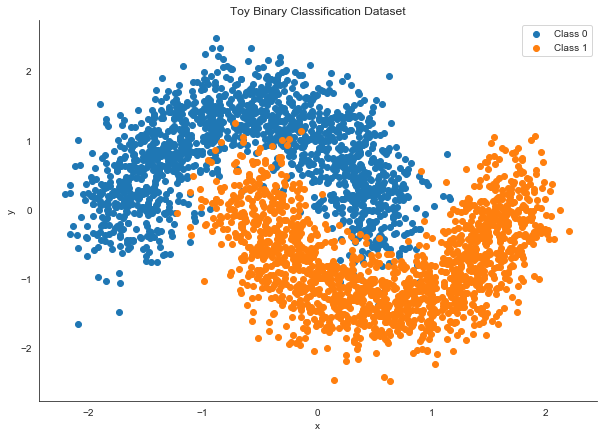

In [112]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x[y==0,0],x[y==0,1], label = 'Class 0', color = 'C0')
ax.scatter(x[y==1,0],x[y==1,1], label = 'Class 1', color = 'C1')
sns.despine()
ax.legend()
ax.set(xlabel = 'x', ylabel = 'y', title = 'Toy Binary Classification Dataset');

- PyMC3은 theano 기반으로 동작
- PyMC3에서는 with 구문으로 모델 정의
- Hidden Layer가 2층이며 각 Layer에서는 10개의 Neuron이 존재하는 경우에 대한 모델을 생성

In [43]:
floatX = theano.config.floatX

In [86]:
def construct_nn(ann_input, ann_output) :
    n_hidden_1 = 10; n_hidden_2 = 5
    
    # Initialize random weighs between each Layer
    init_1   = np.random.randn(x.shape[1], n_hidden_1).astype(floatX)
    init_2   = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2).astype(floatX)
    
    with pm.Model() as neural_network :
        
        # Weights from input to hidden_layer 1
        weights_in_h1 = pm.Normal('w_in_1', 0, sd = 1
                                  , shape = (x.shape[1], n_hidden_1)
                                  , testval = init_1)
        
        # Weights from hidden_layer 1 to hidden_layer 2
        weights_h1_h2 = pm.Normal('w_1_2', 0, sd = 1
                                  , shape = (n_hidden_1, n_hidden_2)
                                  , testval = init_2)
        
        # Weights from hidden_layer 2 to output
        weights_h2_op = pm.Normal('w_2_out', 0, sd =1
                                  , shape = (n_hidden_2,)
                                  , testval = init_out)
        
        # Construct Neural Network using tanh activation function
        
        act_1      = pm.math.tanh(pm.math.dot(ann_input, weights_in_h1))
        act_2      = pm.math.tanh(pm.math.dot(act_1, weights_h1_h2))
        act_output = pm.math.tanh(pm.math.dot(act_2, weights_h2_op))
        
        # Binary Classification via Bernoulli-likelihood
        
        output = pm.Bernoulli('output', act_output, observed = ann_output, total_size = y_tr.shape[0]) 
        
    return neural_network        

In [78]:
ann_input = theano.shared(x_tr)
ann_ouput = theano.shared(y_tr)
neural_network = construct_nn(ann_input, ann_ouput)

In [79]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

- Variational Inference 활용한 weight 추정

In [87]:
with neural_network :
    inference = pm.ADVI()
    approx = pm.fit(n = 3000, method = inference)

Finished [100%]: Average Loss = 524.08


In [ ]:
- 최적화 과정의 objective Function의 

In [91]:
trace = approx.sample(draws=1500)

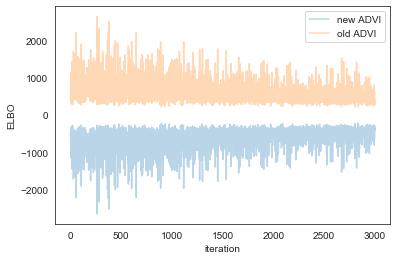

In [92]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

- 모델에 대한 학습이 이루어졌으니, posterior predictive distribution에 대한 예측을 수행

In [113]:
# Replace arrays our NN references with the test data
ann_input.set_value(x_ts)
ann_output.set_value(y_ts)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples = 50, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

In [ ]:
- samples : Numberof  

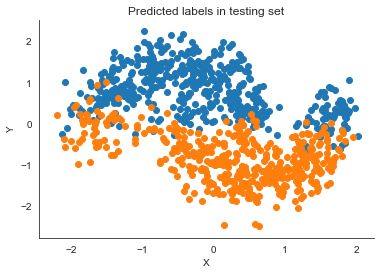

In [114]:
fig, ax = plt.subplots()
ax.scatter(x_ts[pred==0, 0], x_ts[pred==0, 1], label = 'Class 0', color = 'C0')
ax.scatter(x_ts[pred==1, 0], x_ts[pred==1, 1], label = 'Class 0', color = 'C1')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [115]:
print('Accuracy = {}%'.format((y_ts == pred).mean() * 100))

Accuracy = 79.0%


In [13]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [14]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

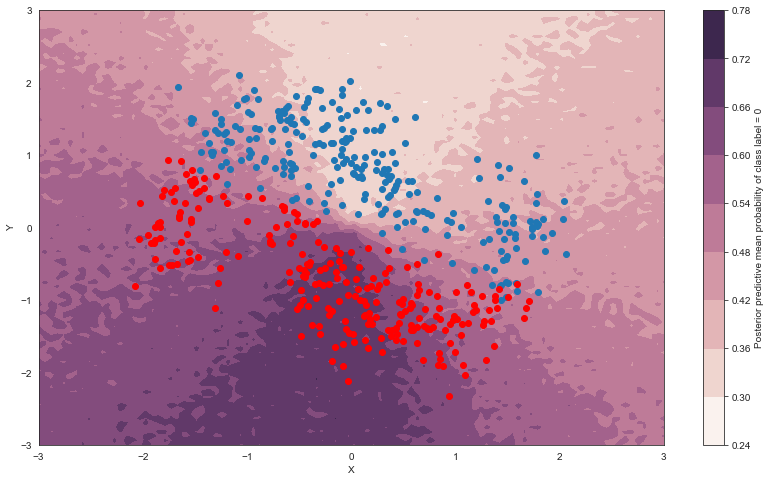

In [17]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

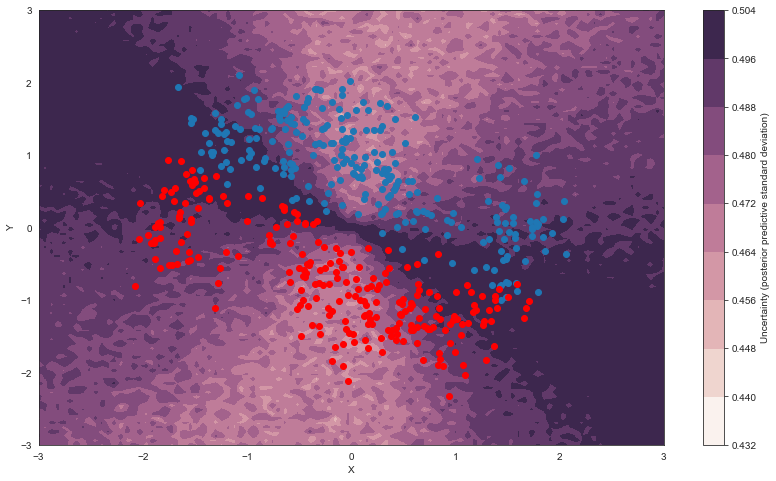

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [20]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(1000, method=inference)

Finished [100%]: Average Loss = 37.13


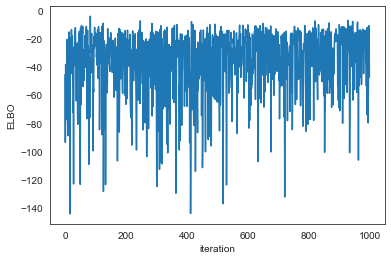

In [21]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [83]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(x.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(x.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=y_tr.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(x_tr)
ann_output = theano.shared(y_tr)
neural_network = construct_nn(ann_input, ann_output)

In [84]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Interrupted at 537 [1%]: Average Loss = 806.27
